In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [3]:
time_series = pd.read_csv('Cleaned_data.csv',index_col = 0)

In [12]:
train_dates= time_series.Date
train_dates

0       2017-01-01
1       2017-01-02
2       2017-01-03
3       2017-01-04
4       2017-01-05
           ...    
2263    2023-03-16
2264    2023-03-17
2265    2023-03-18
2266    2023-03-19
2267    2023-03-20
Name: Date, Length: 2268, dtype: object

**Data Visualiztion**

In [4]:
time_series

,Date,PS,WS10M,WS10M_RANGE,WD10M,T2M,RH2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,Visibility,Cloud Cover,Conditions,weather_type
0,2017-01-01,101.27,0.86,1.29,142.25,19.87,72.81,0.00,138.71,2.5,0.4,Clear,Mist
1,2017-01-02,101.27,0.95,1.33,194.31,19.83,75.44,3.69,135.58,1.1,0.7,Clear,Fog
2,2017-01-03,101.24,2.49,2.16,325.44,18.69,83.31,2.25,134.17,4.0,1.0,Clear,Smoke Or Haze
3,2017-01-04,101.15,2.86,1.96,337.94,18.01,79.00,0.00,148.32,4.0,0.9,Clear,Smoke Or Haze
4,2017-01-05,101.13,2.80,2.20,333.69,17.16,72.50,0.00,166.91,4.0,0.7,Clear,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2023-03-16,100.76,3.98,5.09,174.88,26.80,64.75,2.49,199.41,3.9,97.6,Overcast,Overcast
2264,2023-03-17,100.88,1.73,3.81,148.31,25.20,73.06,4.11,93.95,3.9,98.8,Overcast,Overcast
2265,2023-03-18,100.77,1.32,3.14,215.88,26.46,65.06,2.20,93.95,4.0,96.9,Overcast,Overcast
2266,2023-03-19,100.62,3.70,4.26,188.81,24.49,74.62,2.14,93.95,4.0,99.3,Overcast,Overcast


In [5]:
time_series.drop(['PRECTOTCORR'], axis=1, inplace =True)

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# # time_series.drop(['Date','Conditions','weather_type','Missing'],axis = 1,inplace = True)
# print(scaler.inverse_transform(X_val[-1,-3:]))
# time_series[-18:]

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

# load weather data
weather_data = time_series

# extract relevant columns (temperature, humidity, wind, pressure)
relevant_columns = ['T2M','PS', 'WS10M', 'WS10M_RANGE', 'WD10M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'Visibility']
relevant_data = weather_data[relevant_columns][:].values

# normalize relevant data
scaler = MinMaxScaler()
relevant_data = scaler.fit_transform(relevant_data)

# create sequences of length 30 (i.e., use 30 days to predict the next day)
sequence_length = 15
sequences = []
for i in range(sequence_length, len(relevant_data)):
    sequences.append(relevant_data[i-sequence_length:i+1])

# convert sequences to numpy arrays
sequences = np.array(sequences)

# split data into training and validation sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences = sequences
# val_sequences = sequences[split_index:]

# split training and validation sets into X and y
X_train = train_sequences[:, :-1]
y_train = train_sequences[:,-1,]
# X_val = val_sequences[:, :-1]
# y_val = val_sequences[:,-1,]

# reshape X arrays to include a third dimension for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(relevant_columns)))
# X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(relevant_columns)))

# create LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(len(relevant_columns)))
model.compile(optimizer='adam', loss='mse')

# train model
model.fit(X_train, y_train, epochs=5000, batch_size=1000)

# make predictions for the next 15 days
last_sequence = sequences[-1, :-1]
next_predictions = []
for i in range(25):
    next_prediction = model.predict(last_sequence.reshape((1, sequence_length, len(relevant_columns))))
    next_predictions.append(next_prediction[0])
    last_sequence = np.append(last_sequence[1:], next_prediction, axis=0)

# invert normalization to get predicted temperature values
next_predictions = scaler.inverse_transform(np.array(next_predictions))

# print predicted temperature values for the next 15 days
for i, prediction in enumerate(next_predictions):
    print(f"Day {i+1}: {prediction[0]:.2f} degrees Celsius")

Streaming output truncated to the last 5000 lines.
Epoch 2526/5000
3/3 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 2527/5000
3/3 [==============================] - 0s 22ms/step - loss: 0.0035
Epoch 2528/5000
3/3 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 2529/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.0034
Epoch 2530/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.0035
Epoch 2531/5000
3/3 [==============================] - 0s 22ms/step - loss: 0.0034
Epoch 2532/5000
3/3 [==============================] - 0s 16ms/step - loss: 0.0035
Epoch 2533/5000
3/3 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 2534/5000
3/3 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 2535/5000
3/3 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 2536/5000
3/3 [==============================] - 0s 15ms/step - loss: 0.0034
Epoch 2537/5000
3/3 [===============

In [ ]:
sequences[-1,3 :-1].shape

(22, 8)

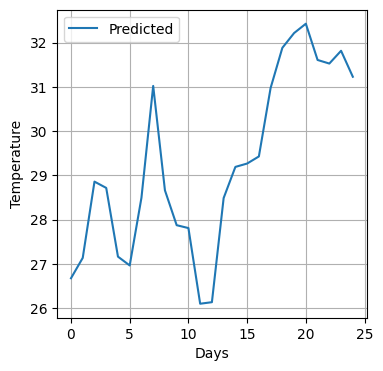

In [9]:
# predictions = np.array(predictions)
y_pred = next_predictions[:,0]
# y_test =np.array(time_series[-15:]['T2M'])

plt.figure(figsize=(4, 4))
# plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Days') 
plt.ylabel('Temperature')
plt.grid()
plt.savefig('temperature_y_test.png', dpi=400,)
plt.show()

In [16]:
f_dates= pd.date_range(list(train_dates)[-1], periods = 26, freq= '1d').tolist()
f_dates[1:]

[Timestamp('2023-03-21 00:00:00', freq='D'),
 Timestamp('2023-03-22 00:00:00', freq='D'),
 Timestamp('2023-03-23 00:00:00', freq='D'),
 Timestamp('2023-03-24 00:00:00', freq='D'),
 Timestamp('2023-03-25 00:00:00', freq='D'),
 Timestamp('2023-03-26 00:00:00', freq='D'),
 Timestamp('2023-03-27 00:00:00', freq='D'),
 Timestamp('2023-03-28 00:00:00', freq='D'),
 Timestamp('2023-03-29 00:00:00', freq='D'),
 Timestamp('2023-03-30 00:00:00', freq='D'),
 Timestamp('2023-03-31 00:00:00', freq='D'),
 Timestamp('2023-04-01 00:00:00', freq='D'),
 Timestamp('2023-04-02 00:00:00', freq='D'),
 Timestamp('2023-04-03 00:00:00', freq='D'),
 Timestamp('2023-04-04 00:00:00', freq='D'),
 Timestamp('2023-04-05 00:00:00', freq='D'),
 Timestamp('2023-04-06 00:00:00', freq='D'),
 Timestamp('2023-04-07 00:00:00', freq='D'),
 Timestamp('2023-04-08 00:00:00', freq='D'),
 Timestamp('2023-04-09 00:00:00', freq='D'),
 Timestamp('2023-04-10 00:00:00', freq='D'),
 Timestamp('2023-04-11 00:00:00', freq='D'),
 Timestamp

In [11]:
y_pred

array([26.677296, 27.137438, 28.860329, 28.718216, 27.165516, 26.966228,
       28.495705, 31.022142, 28.663584, 27.875887, 27.810944, 26.101812,
       26.136316, 28.489382, 29.1929  , 29.268747, 29.428936, 30.976871,
       31.88316 , 32.216763, 32.427628, 31.608784, 31.527697, 31.816196,
       31.22953 ], dtype=float32)

In [17]:
forecast_dates = []
for time_i in f_dates:
    forecast_dates.append(time_i.date())

In [20]:
y_pred.size

25

In [21]:
len(forecast_dates)

26

In [22]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates[1:]), 'T2M':y_pred})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [31]:
df_forecast

In [31]:
time_series.tail(177)

In [26]:
original = time_series[['Date', 'T2M']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-09-25']

<ipython-input-26-be03cca933bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [28]:
import seaborn as sns

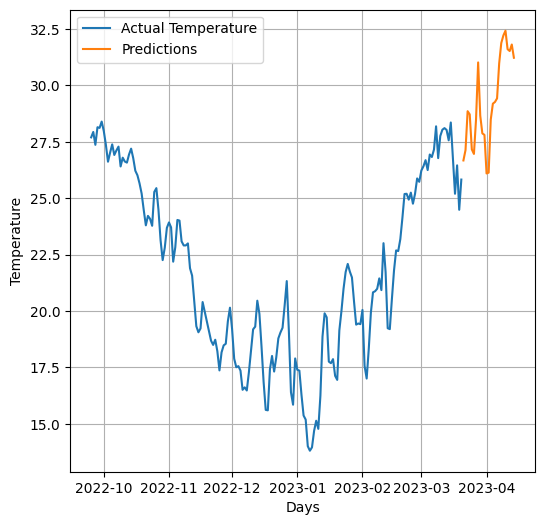

In [31]:
plt.figure(figsize=(6, 6))
plt.plot(original['Date'], original['T2M'], label ='Actual Temperature')
plt.plot(df_forecast['Date'], df_forecast['T2M'], label= 'Predictions')

plt.legend()
plt.xlabel('Days') 
plt.ylabel('Temperature')
plt.grid()
plt.savefig('temperature_y_test.png', dpi=400,)
plt.show()